# **Cross-validation for hyperparameter tuning** 


In order to make sure that your algorithm is efficient and robust, it is necessary to measure its generalization performance. Here, we will illustrate how to perform model selection using k-fold cross-validation. We will use the German credit dataset as an example. 

In this notebook, we will:
1. Load and organise the data 
2. Pre-process the features  
2. Pick a c-SVM classifier and tune the hyperparameters for it 

We will implement the SVC and the cross-validation in [scikit-learn](https://scikit-learn.org/stable/). 


## **Load and Organise data**

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn

Please download the data from the following link: https://drive.google.com/file/d/1t_knbnXYYD7LZopHVc2H2DBm4QId4FEf/view?usp=sharing. If running in Colab, please upload the data to the local folder. Otherwise, place the data in the same folder as the notebook.

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/askoshiyama/mli-cohort/master/german_credit.csv")
df.head()

,default,account_check_status,duration_in_month,credit_history,purpose,credit_amount,savings,present_emp_since,installment_as_income_perc,personal_status_sex,...,present_res_since,property,age,other_installment_plans,housing,credits_this_bank,job,people_under_maintenance,telephone,foreign_worker
0,0,< 0 DM,6,critical account/ other credits existing (not ...,domestic appliances,1169,unknown/ no savings account,.. >= 7 years,4,male : single,...,4,real estate,67,none,own,2,skilled employee / official,1,"yes, registered under the customers name",yes
1,1,0 <= ... < 200 DM,48,existing credits paid back duly till now,domestic appliances,5951,... < 100 DM,1 <= ... < 4 years,2,female : divorced/separated/married,...,2,real estate,22,none,own,1,skilled employee / official,1,none,yes
2,0,no checking account,12,critical account/ other credits existing (not ...,(vacation - does not exist?),2096,... < 100 DM,4 <= ... < 7 years,2,male : single,...,3,real estate,49,none,own,1,unskilled - resident,2,none,yes
3,0,< 0 DM,42,existing credits paid back duly till now,radio/television,7882,... < 100 DM,4 <= ... < 7 years,2,male : single,...,4,if not A121 : building society savings agreeme...,45,none,for free,1,skilled employee / official,2,none,yes
4,1,< 0 DM,24,delay in paying off in the past,car (new),4870,... < 100 DM,1 <= ... < 4 years,3,male : single,...,4,unknown / no property,53,none,for free,2,skilled employee / official,2,none,yes


## **Pre-process variables**

We start by observing which variables are in the dataset, then transform the categorical variables in binary values through one hot encoding. 

In [ ]:
# variable types
df.dtypes

default                        int64
account_check_status          object
duration_in_month              int64
credit_history                object
purpose                       object
credit_amount                  int64
savings                       object
present_emp_since             object
installment_as_income_perc     int64
personal_status_sex           object
other_debtors                 object
present_res_since              int64
property                      object
age                            int64
other_installment_plans       object
housing                       object
credits_this_bank              int64
job                           object
people_under_maintenance       int64
telephone                     object
foreign_worker                object
dtype: object

In [ ]:
# categorical variables
cat_variables = ['account_check_status', 'credit_history', 'purpose', 'savings', 'present_emp_since', 'personal_status_sex',
                'property', 'other_installment_plans', 'housing', 'job', 'telephone', "other_debtors", 'foreign_worker']

# target variable
output_variable = ["default"]

# other integer variables
int_variables = ['credits_this_bank', 'present_res_since', 'duration_in_month', 'people_under_maintenance', 
                 'installment_as_income_perc', 'age', 'credit_amount']

In [ ]:
# pre-allocation
df_cat = pd.DataFrame(index=df.index)

# one-hot encoding of categorical variables
from sklearn.preprocessing import OneHotEncoder

# I will do a loop for pedagogical reasons, but it is not entirely necessary
for cat in cat_variables:
    # one-hot encoding fitting
    one_hot_func = OneHotEncoder().fit(df[[cat]])
    
    # mapping
    cat_mapped = one_hot_func.transform(df[[cat]]).toarray()
    
    # storing
    for (k, cat_label) in enumerate(one_hot_func.categories_[0]):
        df_cat[cat + "_" + cat_label] = cat_mapped[:, k]

We then bin the variable age into three categories: young, adult, senior.

In [ ]:
# bracketing integer variable - age
from sklearn.preprocessing import KBinsDiscretizer
kbin_func = KBinsDiscretizer(n_bins=3, encode='onehot', strategy='quantile').fit(df[["age"]])
df_age = pd.DataFrame(kbin_func.transform(df[["age"]]).toarray(), columns=["young", "adult", "senior"])

# checking
pd.concat([df_age, df[["age"]]], axis=1).head(10)

,young,adult,senior,age
0,0.0,0.0,1.0,67
1,1.0,0.0,0.0,22
2,0.0,0.0,1.0,49
3,0.0,0.0,1.0,45
4,0.0,0.0,1.0,53
5,0.0,1.0,0.0,35
6,0.0,0.0,1.0,53
7,0.0,1.0,0.0,35
8,0.0,0.0,1.0,61
9,0.0,1.0,0.0,28


We also add the log-transformed variables to the datset. 

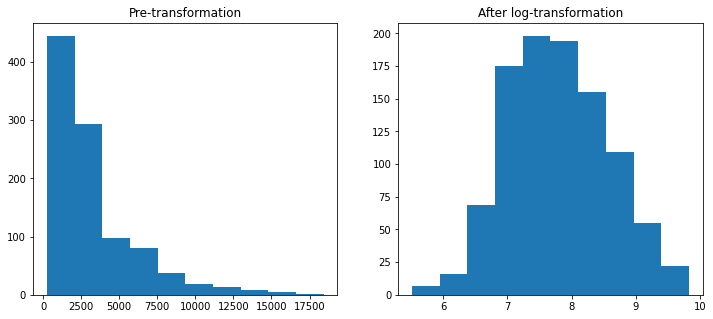

In [ ]:
# other types of transformations possible - log transformation 
from sklearn.preprocessing import FunctionTransformer
log_mapping = FunctionTransformer(func=np.log, inverse_func=np.exp)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.hist(df["credit_amount"])
ax1.set_title("Pre-transformation")

ax2.hist(log_mapping.transform(df["credit_amount"]))
ax2.set_title("After log-transformation")
df_log = pd.DataFrame(log_mapping.transform(df["credit_amount"]).values, columns=["log(credit)"])

Finally, we can finalize and print our dataset

In [ ]:
df_model = pd.concat([df[int_variables[:-2]], df_cat, df_age, df_log, df[output_variable]], axis=1)
df_model.head()

,credits_this_bank,present_res_since,duration_in_month,people_under_maintenance,installment_as_income_perc,account_check_status_0 <= ... < 200 DM,account_check_status_< 0 DM,account_check_status_>= 200 DM / salary assignments for at least 1 year,account_check_status_no checking account,credit_history_all credits at this bank paid back duly,...,other_debtors_co-applicant,other_debtors_guarantor,other_debtors_none,foreign_worker_no,foreign_worker_yes,young,adult,senior,log(credit),default
0,2,4,6,1,4,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,7.063904,0
1,1,2,48,1,2,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,8.691315,1
2,1,3,12,2,2,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,7.647786,0
3,1,4,42,2,2,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,8.972337,0
4,2,4,24,2,3,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,8.490849,1


## **Hyperparameters tuning**

We take a Kernel SVM, select a few possible hyperparameter values to iterate on and metrics to score the model's performance. 

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold

# params
hyper_params = {"kernel_svc__C": [10.00 ** 2, 10.00 ** 3, 10.00 ** 4], # 5
                "kernel_svc__gamma": (np.array([10.0 ** -2, 10.0 ** -1, 10.0 ** 0, 10.0 ** 1, 10.0 ** 2]) * 1.0/df_model.shape[1]).tolist(),
                # [10.0 ** -3, 10.0 ** -2, 10.0 ** -1, 10.0 ** 0, 10.0 ** 1] * 1.0/df_model.shape[1],
                "kernel_svc__kernel": ["rbf"], # rbf (radial basis function) a.k.a. gaussian kernel
                "kernel_svc__probability": [True]
                }

# performance metrics
perf_metrics = {"Accuracy": metrics.accuracy_score, 
                "Precision": metrics.precision_score, 
                "Recall": metrics.recall_score,
                "AUC": metrics.roc_auc_score, 
                "F1-Score": metrics.f1_score, 
                "Brier": metrics.brier_score_loss
               }
for pf in perf_metrics:
    perf_metrics[pf] = metrics.make_scorer(perf_metrics[pf])

We can now create the model pipeline: the data is first scaled to have mean 0 and unit variance, then fed to a kernel SVM. 

We then split the data into three folds using StratifiedKFold, and run the GridSearchCV procedure.

In [ ]:
# main method
# split the data into inputs and output
X, y = df_model.drop(labels=output_variable, axis=1).values, df_model[output_variable].values

# instantiate the model - Pipeline where we scale the variables using StandardScaler = (x - mu)/sigma; kernel SVM
model_pipeline = Pipeline([("scaler", StandardScaler()),
                           ("kernel_svc", SVC())]
                         )

# k-fold cross-validation
k_folds = StratifiedKFold(n_splits=3, random_state=10, shuffle=True) # 3-fold -

# run the grid-search CV procedure
model = GridSearchCV(estimator=model_pipeline, 
                     param_grid=hyper_params, 
                     scoring=perf_metrics, 
                     cv=k_folds, 
                     refit="F1-Score"
                    )
model.fit(X, y.ravel())

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=10, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('kernel_svc', SVC())]),
             param_grid={'kernel_svc__C': [100.0, 1000.0, 10000.0],
                         'kernel_svc__gamma': [0.00015625, 0.0015625, 0.015625,
                                               0.15625, 1.5625],
                         'kernel_svc__kernel': ['rbf'],
                         'kernel_svc__probability': [True]},
             refit='F1-Score',
             scoring={'AUC': make_scorer(roc_auc_score),
                      'Accuracy': make_scorer(accuracy_score),
                      'Brier': make_scorer(brier_score_loss),
                      'F1-Score': make_scorer(f1_score),
                      'Precision': make_scorer(precision_score),
                      'Recall': make_scorer(recall_score)})

We can understand GridSearchCV to do: 

```
for every hyperparameter:
 for every (train, test) fold:
    model_pipeline.fit(X[train], y[train])
    model_pipelin.predict(X[test], y[test])
    compute performance metrics
    store results
```




## **Display results**

In [ ]:
# get best model
best_model = model.best_estimator_
best_model

Pipeline(steps=[('scaler', StandardScaler()),
                ('kernel_svc',
                 SVC(C=100.0, gamma=0.0015625, probability=True))])

In [ ]:
# store all results and avg results in a df
df_cv = pd.DataFrame(model.cv_results_)

# add a hyperparameter column in avg df
from sklearn.model_selection import ParameterGrid
df_hyperparams = pd.DataFrame(list(ParameterGrid(model.param_grid)))
df_avgcv = pd.DataFrame(columns=perf_metrics.keys())
for pf in perf_metrics.keys():
    df_avgcv[pf] = df_cv["mean_test_" + pf]
df_avgcv = pd.concat([df_hyperparams, df_avgcv], axis=1)

We can now display the results in a table. Here, we are sorting them by accuracy.

In [ ]:
df_avgcv.sort_values('Accuracy', ascending=False)

,kernel_svc__C,kernel_svc__gamma,kernel_svc__kernel,kernel_svc__probability,Accuracy,Precision,Recall,AUC,F1-Score,Brier
1,100.0,0.001563,rbf,True,0.758004,0.619780,0.493333,0.682368,0.547698,0.241996
0,100.0,0.000156,rbf,True,0.753013,0.630089,0.420000,0.657850,0.502616,0.246987
10,10000.0,0.000156,rbf,True,0.751002,0.602945,0.493333,0.677367,0.541495,0.248998
5,1000.0,0.000156,rbf,True,0.748998,0.605774,0.463333,0.667359,0.522371,0.251002
2,100.0,0.015625,rbf,True,0.730988,0.561300,0.480000,0.659268,0.516906,0.269012
7,1000.0,0.015625,rbf,True,0.729987,0.559229,0.480000,0.658553,0.515961,0.270013
12,10000.0,0.015625,rbf,True,0.729987,0.559229,0.480000,0.658553,0.515961,0.270013
6,1000.0,0.001563,rbf,True,0.711993,0.521850,0.493333,0.649513,0.507003,0.288007
4,100.0,1.562500,rbf,True,0.702001,0.666667,0.006667,0.503333,0.013201,0.297999
9,1000.0,1.562500,rbf,True,0.702001,0.666667,0.006667,0.503333,0.013201,0.297999
